## 高维线性回归实验

下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1, x_2, \ldots, x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i +  \epsilon,$$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
# n_train训练样本数，n_test测试样本数，num_inpyts输入特征数
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 从零开始实现

#### 初始化模型参数

In [2]:
# 为每个参数附上梯度
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

#### 定义L_2范数惩罚项

In [5]:
# 这里只惩罚模型的权重参数
def l2_penalty(w):
    return (w**2).sum() / 2

#### 定义训练和测试

In [6]:
batch_size, num_epochs, lr = 1, 100, 0.003
# 线性模型和平方损失函数
net, loss = d2l.linreg, d2l.squared_loss
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 此处与之前不同， 添加了L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

#### 观察过拟合

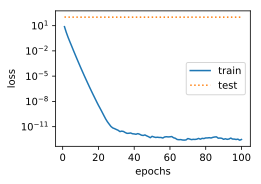

L2 norm of w: 12.904754


In [7]:
# lambd为0，没有用权重衰减，典型的过拟合
fit_and_plot(lambd=0)

#### 使用权重衰减

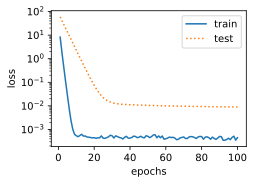

L2 norm of w: 0.042179428


In [8]:
# 虽然训练误差比刚才大，但是测试集上的误差有所下降，一定程度的缓解了过拟合，
# 另外，权重参数的L_2范数比不使用权重衰减时的更小，此时的权重参数更接近0
fit_and_plot(lambd=3)

#### 简洁实现

In [9]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数衰减。权重名称一般是以weight结尾，加参数wd，wd就是前面的lambda值
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd',
                              {'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称一般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                              {'learning_rate': lr})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调用step函数，从而分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

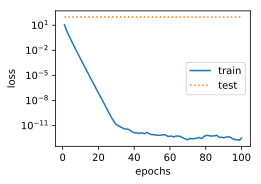

L2 norm of w: 13.6713915


In [10]:
fit_and_plot_gluon(0)

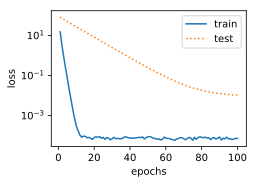

L2 norm of w: 0.06079024


In [16]:
fit_and_plot_gluon(1)

## 小结

* 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
* 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0。
* 权重衰减可以通过Gluon的`wd`超参数来指定。
* 可以定义多个`Trainer`实例对不同的模型参数使用不同的迭代方法。

## 练习

* 回顾一下训练误差和泛化误差的关系。除了权重衰减、增大训练量以及使用复杂度合适的模型，你还能想到哪些办法来应对过拟合？
* 如果你了解贝叶斯统计，你觉得权重衰减对应贝叶斯统计里的哪个重要概念？
* 调节实验中的权重衰减超参数，观察并分析实验结果。